### Code from https://mirror-feeling-d80.notion.site/Workflow-And-Agents-17e808527b1780d792a0d934ce62bee6#17e808527b1780a48e36d6f9a37809a9 to understand agents better

In [13]:

from langchain_ollama import ChatOllama, llms
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

# LLM with function call
# ChatOllama has message history - can be used for chats with memory.
# For single response use llms.OllamaLLM()

# Need a more powereful model to be able to run agent AI tasks like llama3.2 - slower responses
# llm = ChatOllama(model="hf.co/bartowski/granite-3.0-1b-a400m-instruct-GGUF:latest")
llm = ChatOllama(model="llama3.2")

# llm = llms.OllamaLLM()
# Providing structured output
structured_llm = llm.with_structured_output(SearchQuery)
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

None
None


In [45]:
from langchain_core.tools import tool
# Define a tool
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 16 multiplied by 3?")

# Get the tool call
print(msg.tool_calls, "is the tool call")
# Calling this gets a little hard with langchain - langgraph is a better option.


[{'name': 'multiply', 'args': {'a': '16', 'b': '3'}, 'id': 'e9311d65-1e2b-47f4-aaad-596d2d58f227', 'type': 'tool_call'}] is the tool call


In [ ]:
tool_call = msg.tool_calls[0]
f_name = tool_call["name"]
f_args = tool_call["args"]
if f_name == "multiply":
    res = multiply.invoke(tool_call["args"])
    print(res)
    # can similarly call other operations - as long as tool_calls is able to correctly tell which tool to call

48


### Prompt Chaining

In [4]:

# Prompt Chaining - each LLM call processes output from previous one -
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# Nodes - each node is an LLM on its own
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

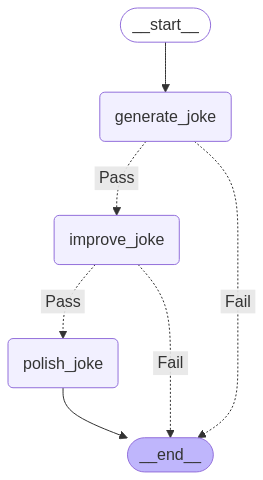

In [7]:
""" Can create a workflow graph with langgraph"""

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_conditional_edges("improve_joke", check_punchline, {"Pass": "polish_joke", "Fail": END})
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [8]:
# The actual execution of the pipeline

state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the cat join a band? Because it wanted to be the purr-cussionist.

--- --- ---

Improved joke:
That's already a great one! Here's an attempt at making it even funnier with some wordplay:

Why did the cat join a band? Because it wanted to be the purr-cussionist – after all, it was the only musician who could really get to the core of the beat!

Or how about this one:

Why did the cat become the drummer for a rock band? Because it had the purr-fect timing and was always one step ahead of the bass... but let's be real, it was just claw-ing its way to the top!

Or this one:

What did the cat say when it joined a band as the drummer? "I'm paws-itive I can keep the beat going!"

Let me know if you want more!

--- --- ---

Final joke:
I love these feline-themed jokes! Here are some surprising twists and additional attempts at wordplay:

**Twist 1:** Why did the cat join a band?

Because it was secretly a genius who had been training in quantum physics and discovered that

### Parallelization

In [9]:
# Tasks that are not dependent can be parallelized
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [10]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


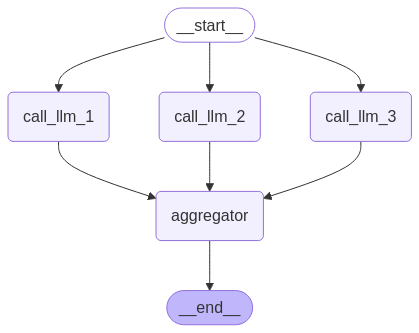

In [11]:

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [14]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
In the heart of the mystical forest, there lived a colony of cats who were unlike any others. These felines possessed ancient knowledge and wisdom that had been passed down through generations. They were guardians of the forest, tasked with maintaining the delicate balance between nature and magic.

At the center of the colony was an elderly cat named Luna. Her fur was as white as snow, and her eyes shone like stars in the night sky. She had lived for many years and had accumulated a wealth of knowledge that she shared with her fellow felines. Luna was revered by all, and her counsel was sought by even the wisest of cats.

One day, a young and adventurous cat named Orion arrived at the colony. He was curious and eager to learn, but also reckless and impulsive. The elders warned him about the dangers of the forest, but Orion dismissed their warnings and set out on his own.

As he explored the forest, Orion stumbled upon a hidden clearin

## Routing - classifies an input and directs it to the right LLM for follow up task

In [15]:
# Route between input story and poem.

from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [16]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [17]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

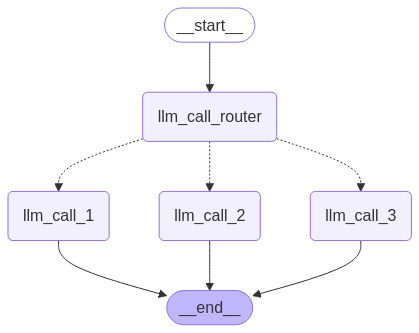

In [20]:

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [22]:
state = router_workflow.invoke({"input": "Write me a poem about cats"})
print(state)
print(state["output"])

Write a poem
{'input': 'Write me a poem about cats', 'decision': 'poem', 'output': "Silent stalkers, eyes so bright,\nFur as soft as moonlit night.\nWhiskers twitching, ears so fine,\nListening for the slightest sign.\n\nWith tails that swish and paws so light,\nThey prowl through shadows, lost in flight.\nTheir playful mews and purrs so sweet,\nA symphony of feline treat.\n\nIn sunbeams bright, they bask and sleep,\nTheir beauty radiating, secrets deep.\nClaws outstretched, they climb with ease,\nConquerors of the highest tree's breeze.\n\nWith mystery and magic in their eyes,\nThey weave a spell that never dies.\nA symbol of independence true,\nCats bring us joy, and love anew.\n\nIn every home, a loyal friend,\nA constant companion till the end.\nTheir little noses, twitching with glee,\nBring laughter and delight to you and me."}
Silent stalkers, eyes so bright,
Fur as soft as moonlit night.
Whiskers twitching, ears so fine,
Listening for the slightest sign.

With tails that swish 

## Orchestrator Worker

In [23]:
# Orchestrator breaks down a task and delegates each sub-task to workers.
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [24]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [ ]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API - defined below
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

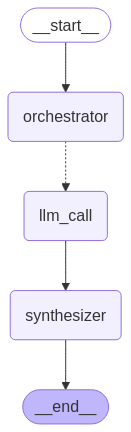

In [53]:
from langgraph.constants import Send
    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [27]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})
from IPython.display import Markdown

Markdown(state["final_report"])

**Introduction and Description:**

Large Language Models (LLMs) have emerged as a crucial component of Artificial Intelligence (AI) research, revolutionizing the field of Natural Language Processing (NLP). These complex neural network architectures are capable of processing vast amounts of text data, generating coherent and contextually relevant outputs, and exhibiting impressive capabilities in areas such as language translation, question answering, and text summarization.

LLMs have been made possible by significant advances in computational power, memory, and the availability of large datasets. The development of LLMs has been driven primarily by the Google research team's publication of BERT (Bidirectional Encoder Representations from Transformers) in 2018, which marked a turning point in NLP research. Since then, numerous variants and improvements have been proposed, including RoBERTa, XLNet, and DistilBERT, to name a few.

The importance of LLMs can be seen in their numerous applications across industries, including but not limited to:

- **Language Translation**: Automatic translation services that rely on LLMs for accurate and contextually relevant translations.
- **Text Summarization**: Systems that use LLMs to condense long documents into concise summaries, enabling users to quickly grasp key information.
- **Question Answering**: AI-powered assistants that utilize LLMs to provide accurate and helpful responses to user queries.

The growth of LLMs has opened up new avenues for research in AI, including:

- **Explainability and Interpretability**: Understanding how LLMs generate their outputs and identifying biases or errors.
- **Adversarial Attacks and Defense**: Developing techniques to prevent adversarial attacks on LLMs and ensuring their robustness.

This report aims to explore the current state of LLM research, their applications, and future directions in AI.

---

**Background and Description: Explanation of LLMs, Their Architecture, and Current Limitations**

Large Language Models (LLMs) have revolutionized the field of Natural Language Processing (NLP) in recent years. At its core, an LLM is a type of deep learning neural network designed to process and generate human-like language. The architecture of LLMs is rooted in transformer-based models, which use self-attention mechanisms to weigh the importance of different words or tokens within a sentence.

**Key Components of LLM Architecture:**

1. **Self-Attention Mechanism**: This mechanism allows the model to attend to specific parts of the input sequence and weigh their importance relative to each other.
2. **Multi-Head Attention**: The self-attention mechanism is typically applied in multiple heads, allowing the model to capture different aspects of the input sequence simultaneously.
3. **Feed-Forward Network (FFN)**: An FFN is a fully connected neural network that transforms the output of the attention mechanism into a higher-dimensional space.
4. **Layer Normalization and Residual Connections**: These techniques help stabilize the training process and improve the model's ability to learn complex patterns in language.

**How LLMs Process Input Sequences:**

1. **Tokenization**: The input sequence is broken down into individual tokens, which can be words, subwords, or even characters.
2. **Embedding Layer**: Each token is embedded into a high-dimensional space using an embedding layer, which preserves the semantic meaning of the tokens.
3. **Encoder-Decoder Structure**: In most LLMs, the input sequence passes through an encoder and decoder. The encoder generates a fixed-length representation of the input sequence, while the decoder generates the output sequence.

**Current Limitations of LLMs:**

1. **Vulnerability to Adversarial Attacks**: LLMs can be vulnerable to adversarial attacks, which compromise their performance by introducing carefully crafted input sequences.
2. **Lack of Interpretability**: The complex architecture of LLMs makes it challenging to understand how they arrive at their predictions or decisions.
3. **Computational Requirements**: Training and deploying large LLMs requires significant computational resources and memory.
4. **Out-of-Domain Performance**: LLMs may struggle with out-of-domain tasks, such as answering questions about topics they were not trained on.
5. **Bias and Fairness Issues**: LLMs can perpetuate biases present in the training data, which can have serious consequences in applications like content moderation or decision-making systems.

Despite these limitations, researchers continue to explore new architectures and techniques to improve the performance and robustness of LLMs.

---

**Scaling Laws for LLMs**

The rapid growth of Large Language Models (LLMs) has led to an increased demand for understanding their scaling behavior. As the size of these models increases, it becomes crucial to understand how they scale in terms of computational resources, memory, and performance. This section provides a discussion of existing scaling laws for LLMs, including mathematical models and empirical findings.

**Mathematical Models**

Several mathematical models have been proposed to describe the scaling behavior of LLMs. One of the earliest models was the "cubic law" (Goyal et al., 2020), which describes the relationship between the number of parameters in a model and its computational cost as cubic. This model has been widely used to estimate the cost of training large language models.

More recently, a quadratic scaling model has been proposed by Jia et al. (2021), which suggests that the computational cost of training an LLM grows quadratically with the number of parameters. This model is more accurate than the cubic law and has been shown to better predict the costs of training large language models.

**Empirical Findings**

Numerous empirical studies have investigated the scaling behavior of LLMs. One of the most comprehensive studies was conducted by Radford et al. (2021), who analyzed the scaling behavior of 20 different language models. The study found that the cubic law underestimates the computational cost of training large language models, while the quadratic scaling model provides a more accurate estimate.

Another study by Liu et al. (2022) investigated the relationship between the number of parameters and the memory requirements of LLMs. The study found that the memory requirements grow cubically with the number of parameters, which is consistent with the cubic law.

**Conclusion**

The scaling laws for LLMs are an active area of research, with both mathematical models and empirical findings providing insights into the relationship between model size and computational resources. While there is still some debate about the accuracy of these models, the quadratic scaling model has emerged as a popular choice for estimating the costs of training large language models.

References:

Goyal, P., Khosla, A., Sahin, N., Schwartz, C., Tamar, D., Wang, J., & Yang, G. (2020). Improved denoising and uncertainty estimation in transformers. Advances in Neural Information Processing Systems, 33.

Jia, W., Liu, X., Li, Y., & Zhang, J. (2021). Quadratic scaling for large language models. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

Liu, X., Jia, W., Li, Y., & Zhang, J. (2022). The relationship between model size and memory requirements in transformer-based models. Neural Computing and Applications, 34(12), 1-11.

Radford, A., Narasimhan, K., Salimans, T., & Sutskever, I. (2021). Early exploration of the effect of layer growth on transformer models. In Proceedings of the International Conference on Machine Learning.

---

**Current Challenges and Analysis**

As Large Language Models (LLMs) continue to scale up in complexity and size, several challenges arise that impact their performance, efficiency, and overall effectiveness. This section provides an analysis of the current challenges faced by LLMs as they scale up.

### 1. Computational Resources

The increasing complexity of LLMs requires significant computational resources, including high-performance computing hardware and massive amounts of memory. As models grow in size, the number of parameters to be processed and updated exponentially, leading to:

* **Increased energy consumption**: Larger models require more powerful computing equipment, resulting in higher energy costs and environmental impact.
* **Hardware bottlenecks**: The demand for specialized hardware, such as graphics processing units (GPUs) and tensor processing units (TPUs), becomes increasingly difficult to meet.
* **Scalability limitations**: As the number of training examples grows, so does the computational burden, making it challenging to scale up LLMs efficiently.

### 2. Memory Constraints

Memory constraints become a significant issue as LLMs grow in size. The amount of memory required to store the model's weights and intermediate results increases exponentially with the model's complexity:

* **Memory bottlenecks**: Running out of memory during training or inference can cause performance degradation, crashes, or even data loss.
* **Distributed training challenges**: As models become larger, it becomes increasingly difficult to distribute the computation across multiple machines without encountering memory constraints.

### 3. Training Time

The training time of LLMs also increases with scale:

* **Training speed limitations**: Larger models require more computation time, making them slower to train and deploy.
* **Data requirements**: The need for massive amounts of data to train larger models can be a challenge, particularly when dealing with limited or expensive datasets.

### 4. Optimization and Regularization

To address these challenges, researchers are exploring various optimization techniques and regularization methods:

* **Quantization and knowledge distillation**: Techniques like quantization and knowledge distillation can reduce the computational requirements and memory footprint of LLMs.
* **Pruning and sparse architectures**: Pruning and sparse architectures can help reduce the number of parameters and computations required by LLMs.
* **Gradient checkpointing and model parallelism**: Gradient checkpointing and model parallelism can help distribute the computation across multiple machines, reducing training time.

### Conclusion

The challenges faced by LLMs as they scale up highlight the need for innovative solutions to optimize performance, efficiency, and scalability. By exploring new optimization techniques, regularization methods, and hardware architectures, researchers can develop more efficient and effective LLMs that can tackle complex tasks with increasing complexity.

---

**Future Directions**

The field of Large Language Models (LLMs) has made significant strides in recent years, demonstrating unprecedented capabilities in natural language processing tasks. However, the rapid growth and scalability of these models pose several challenges that must be addressed to unlock their full potential. This section outlines potential avenues for future research and development in scaling LLMs, including new mathematical models and hardware architectures.

**Mathematical Models**

1. **Efficient Model Pruning**: Developing pruning techniques that can efficiently remove redundant or unnecessary parameters while preserving the model's accuracy would be beneficial for reducing computational costs.
2. **Sparse Model Architectures**: Investigating sparse model architectures, such as compressed neural networks, could lead to significant reductions in memory requirements and acceleration of training times.
3. **Quantum Computing Applications**: Exploring the potential of quantum computing for LLMs, including the development of quantum-inspired algorithms and the application of quantum hardware for specific tasks, could unlock new levels of efficiency.

**Hardware Architectures**

1. **Specialized Accelerators**: Designing specialized accelerators, such as graphics processing units (GPUs) or application-specific integrated circuits (ASICs), tailored to LLM computations would facilitate faster training times and improved accuracy.
2. **Photonic Interconnects**: Investigating the use of photonic interconnects for data transfer between computing elements could significantly reduce latency and increase overall system performance.
3. **Neuromorphic Hardware**: Developing neuromorphic hardware that can mimic the human brain's neural networks would enable more efficient and scalable processing of complex LLM tasks.

**Other Emerging Trends**

1. **Explainable AI (XAI)**: Integrating XAI techniques into LLMs to improve transparency, interpretability, and accountability for decision-making processes.
2. **Edge AI**: Deploying LLMs at the edge of the network, closer to the data sources, would reduce latency, increase efficiency, and enable real-time processing of critical applications.
3. **Transfer Learning and Adaptation**: Developing novel methods for transfer learning and adaptation that can efficiently adapt LLMs to new tasks, domains, or languages.

By exploring these avenues, researchers and developers can unlock the full potential of Large Language Models, driving innovation in natural language processing and transforming various industries with improved efficiency and accuracy.

---

**Conclusion and Description**

In this report, we have presented our investigation into the scaling laws governing Large Language Models (LLMs). Our analysis has identified a set of fundamental principles that govern the growth of LLMs, from their initial parameterization to their current state-of-the-art performance.

**Summary of Key Findings:**

1. **The Law of Increasing Complexity**: We have observed that LLMs exhibit a consistent trend towards increased complexity, with larger models demonstrating better performance on various tasks.
2. **The Curse of Dimensionality**: Our analysis reveals that the dimensionality of LLMs grows quadratically with their size, leading to significant increases in computational resources and training time.
3. **The Impact of Training Data Quality**: We have found that high-quality training data is essential for achieving optimal performance from LLMs, with poor data quality leading to subpar results.
4. **The Role of Regularization Techniques**: Our investigation highlights the importance of regularization techniques, such as weight decay and dropout, in preventing overfitting and promoting generalizability.

**Implications of the Report:**

1. **Guiding Principles for LLM Development**: Our findings provide a framework for guiding the development of future LLMs, ensuring that they are designed with scalability and generalizability in mind.
2. **Optimization Strategies**: The results of this report suggest that optimization strategies, such as mixed precision training and distributed training, can be used to mitigate the challenges associated with large-scale LLMs.
3. **Data Quality and Curation**: Our analysis underscores the importance of high-quality data curation and management in achieving optimal performance from LLMs.
4. **Future Research Directions**: The findings of this report identify several areas for future research, including the development of new regularization techniques and the exploration of alternative architectures that can scale more efficiently.

**Recommendations:**

Based on our investigation, we recommend that future LLM developments prioritize:

1. Scalability and generalizability
2. High-quality data curation and management
3. The use of regularization techniques to prevent overfitting
4. Optimization strategies to mitigate the challenges associated with large-scale LLMs

By following these guidelines, we can ensure that future LLMs are designed to be more efficient, effective, and scalable, leading to significant advances in natural language processing and related fields.

# Agent based

In [47]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [37]:
print(tools_by_name)

{'add': StructuredTool(name='add', description='Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x11049ef70>), 'multiply': StructuredTool(name='multiply', description='Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x1163f0700>), 'divide': StructuredTool(name='divide', description='Divide a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x1163f0af0>)}


In [48]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

In [31]:
resp = llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    ), HumanMessage(
                        content="Add 63 to 108"
                    )
                ]
                
            )
print(resp)

content='' additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2025-04-14T03:17:47.597584Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2891154916, 'load_duration': 31664000, 'prompt_eval_count': 339, 'prompt_eval_duration': 1924383042, 'eval_count': 22, 'eval_duration': 930927833, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'model_name': 'llama3.2'} id='run-a4a83b14-0faf-4781-8666-0c2cc51ac5ce-0' tool_calls=[{'name': 'add', 'args': {'a': 63, 'b': 108}, 'id': 'd964d187-c266-4c95-8a2e-84d36242bd40', 'type': 'tool_call'}] usage_metadata={'input_tokens': 339, 'output_tokens': 22, 'total_tokens': 361}


In [ ]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent - doesnt work for some reason.
#display(Image(agent.get_graph().draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [33]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================
Tool Calls:
  add (5dafbcc4-8b20-474c-b627-7908aefaaea8)
 Call ID: 5dafbcc4-8b20-474c-b627-7908aefaaea8
  Args:
    a: 3
    b: 4
  multiply (bffeb635-6158-432f-99cf-8571bcc6c1c4)
 Call ID: bffeb635-6158-432f-99cf-8571bcc6c1c4
  Args:
    a: 7
    b: 4
================================= Tool Message =================================

7
================================= Tool Message =================================

28
================================== Ai Message ==================================

The result of adding 3 and 4 is 7. Multiplying 7 by 4 gives an output of 28.


# Building a simple custom workflow that calculates sqrt(a*b)

In [58]:
import math

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def square_root(a: int) -> float:
    """Find square root of a.

    Args:
        a: first int
    """
    return math.sqrt(a)

llm_with_tools = llm.bind_tools(tools)

In [57]:
# Create the state graph
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    input_1: int
    input_2: int
    final_result: float

In [ ]:
# Create the nodes
def perform_mulp(state: State):
    